In [3]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
!cd /Users/dan/Desktop/LMR_py3

# prefix for figure filename
fig_prefix='prior_truth_'

In [4]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


Loading information from datasets.yml
Loading information from grid_def.yml


In [5]:
# use this when revising modules; this reloads
import importlib
importlib.reload(LMRlite)
importlib.reload(LMR_utils)
importlib.reload(LMR_config)

Loading information from datasets.yml
Loading information from grid_def.yml


<module 'LMR_config' from '/Users/dan/Desktop/LMR_py3/LMR_config.py'>

In [6]:
# load proxies
lmr_names = ['ccsm4_historical',
             'mpi-esm-p_historical',
             'hadcm3_historical']
cfile = './configs/config.yml.nullspace.'+lmr_names[0]
yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
cfg = LMRlite.load_config(yaml_file)

prox_manager = LMRlite.load_proxies(cfg)
numprox = len(prox_manager.all_proxies)

Checking configuration ... 
OK!
                                 Bivalve_d18O :     1
               Corals and Sclerosponges_Rates :     8
                Corals and Sclerosponges_SrCa :    25
                Corals and Sclerosponges_d18O :    59
                        Ice Cores_MeltFeature :     1
                               Ice Cores_d18O :    28
                                 Ice Cores_dD :     7
                              Lake Cores_Misc :     2
                             Lake Cores_Varve :     5
                       Tree Rings_WidthPages2 :   347
                       Tree Rings_WoodDensity :    59
                                        TOTAL :   542
-----------------------------------------------------
completed in 3.108947992324829 seconds
-----------------------------------------------------


In [7]:
def mk_pproxies_sparse(X,Xbp,prox_manager,SNR,grid,complete):

    """
    Construct pseudoproxies 
    """

    numprox = len(prox_manager.ind_assim)

    vY = np.zeros([numprox,grid.nens])
    vR = []
    vP = []

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon

        # Make pproxies
        if complete[npos]:
            # Noise amplitude corresponding to SNR by stdev
            sig = np.std(Xbp[npos,:])
            vY[proxy_idx,:] = Xbp[npos,:] + np.random.randn(grid.nens,)*sig/SNR
            vR.append((sig/SNR)**2)
            vP.append(proxy_idx)

    return vY, vR, vP

def mk_yes(X,Xbp,prox_manager,grid,complete):

    vYe = np.zeros([0,grid.nens])
    vYe_coords = np.zeros([0,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        if complete[npos]:
            vYe[proxy_idx,:] = Xbp[npos,:]
            vYe_coords[proxy_idx,:] = X.coords[npos,:]

    return vYe, vYe_coords


In [8]:
def mk_pproxies(X,Xbp,prox_manager,SNR,grid):

    """
    Construct pseudoproxies 
    """

    numprox = len(prox_manager.ind_assim)

    vY = np.zeros([numprox,grid.nens])
    vR = []
    vP = []

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon

        # Noise amplitude corresponding to SNR by stdev
        sig = np.std(Xbp[npos,:])
        #print(sig)
        #print(sig/SNR)
        # Make pproxies
        vY[proxy_idx,:] = Xbp[npos,:] + np.random.randn(grid.nens,)*sig/SNR
        vR.append((sig/SNR)**2)
        vP.append(proxy_idx)

    return vY, vR, vP

def mk_yes(X,Xbp,prox_manager,grid):

    vYe = np.zeros([numprox,grid.nens])
    vYe_coords = np.zeros([numprox,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]

    return vYe, vYe_coords


In [9]:
# Load and interpolate all of the priors I want to use as truth

lmr_names = ['ccsm4_historical',
             'mpi-esm-p_historical',
             'hadcm3_historical']
model_names = ['CCSM4','MPI-ESM','HadCM3']

# Initialize an array of various interpolated model fields
ada = []

for ii in np.arange(len(lmr_names)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)
    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names[ii]
    dd['lmr_name'] = lmr_names[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ada.append(dd)
        


Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_historical/tas_sfc_Amon_CCSM4_historical_185001-200512.nc
(1872, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= -0.1768212  , std-dev= 1.9386224
Detrending the prior for variable: tas
tas : Global(monthly/detrend): mean= -6.981234e-10  , std-dev= 1.8800453
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 6.795157345955281e-11  , std-dev= 0.8011864973566752
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 50 ensemble members
regridding prior...
0 55295
(55296, 50)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -5.28564977645

In [10]:
nc = 50

In [37]:
# Process HadCRUT like a prior

ad = ada.copy()

# Load HadCRUT
from load_gridded_data import read_gridded_data_HadCRUT
time_yrs,lat,lon,value_t = read_gridded_data_HadCRUT('/Users/dan/Desktop/LMR_py3/data/analyses/','HadCRUT.4.4.0.0.median.nc',['Tsfc'],'annual',[1980,1991])

# Restrict myself to a certain time frame
vt = np.delete(value,np.arange(value.shape[0]-nc),0)
# Remove the mean
vt=vt-np.mean(vt,0)
# Change to 0:360
vt3=np.concatenate([vt[:,:,36:],vt[:,:,:36]],2)

# Isolate points I want to solve for

complete = np.sum(~np.isnan(vt3[-nc:,:,:]),0)==nc
# Set others to zero
hXbp = np.zeros(vt3.shape)
#hXbp[-nc:,complete] = vt3[-nc:,complete]

# Detrend
from scipy import signal
hXbp[-nc:,complete] = signal.detrend(vt3[-nc:,complete],0)

# append to the prior object
#Xs = ad[0]['X']
X.coords = ad[0]['X'].coords
#Xs.coords = ad[0]['X'].coords[complete.ravel(),:]

dd = {}
dd['X']        = X
#dd['Xs']       = Xs
dd['Xbp']      = hXbp.reshape([nc,36*72]).T
#dd['Xbps']     = hXbp[:,~(np.sum(hXbp,0)==0)]
#dd['Xbps']     = hXbp[:,complete.ravel()]
dd['name']     = 'HadCRUT'
dd['lmr_name'] = 'HadCRUT'
dd['grid']     = ad[0]['grid']
ad.append(dd)

/Users/dan/Desktop/LMR_py3/load_gridded_data.py:245: RuntimeWarning: Mean of empty slice
  climo_month[i] = np.nanmean(value[indsmref], axis=0)
/Users/dan/Desktop/LMR_py3/load_gridded_data.py:267: RuntimeWarning: Mean of empty slice
  tmp = np.nanmean(value[ind],axis=0)


In [38]:
# Find ob locations that work with hadcrut
vYe_temp, vYe_coords_temp = mk_yes(ad[0]['X'],np.tile(complete.ravel(),[ad[0]['grid'].nens,1]).T,prox_manager,ad[0]['grid'])
c_dat = np.sum(vYe_temp,1)!=0.
mask = np.tile(complete.ravel(),[nc,1]).T
#priormask = np.tile(complete.ravel(),[ad[0]['grid'].nens,1]).T
nanmask = np.ones(np.tile(complete.ravel(),[nc,1]).T.shape)
nanmask[~mask] = np.nan

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


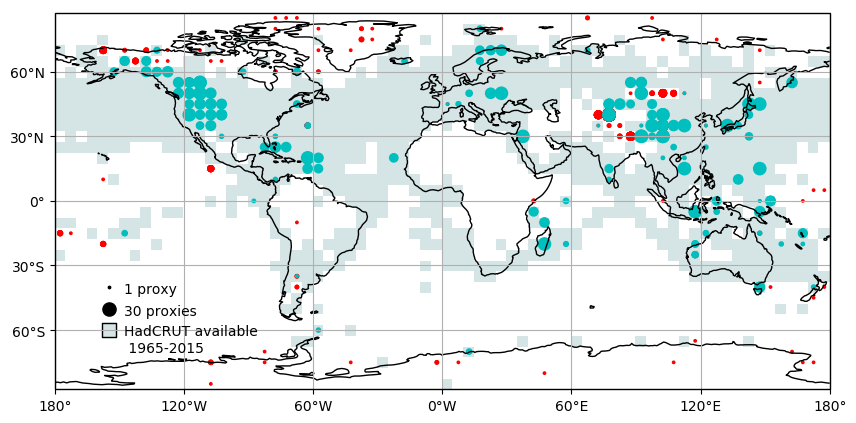

In [39]:
# Plot HadCRUT and pproxy data locations
import cartopy.util as cutil
import cartopy.crs as ccrs
importlib.reload(plt)
plt.style.use('default')

npp = np.empty([len(vYe_coords_temp),1])
for ii in np.arange(len(vYe_coords_temp)):
    npp[ii] = np.sum((vYe_coords_temp[:,0]==vYe_coords_temp[ii,0]) & 
                    ((vYe_coords_temp[:,1]==vYe_coords_temp[ii,1])))
    
    
vYe_coords_plot = vYe_coords_temp[c_dat,:]

#plt.imshow(165-np.flipud(np.sum(np.isnan(value),0)))
#plt.title('Number of years with obs in HadCRUT')
#plt.colorbar()
#plt.show()

fig = plt.figure(figsize=(10,5))

wrap_data, wrap_lon = cutil.add_cyclic_point(complete, coord=grid.lon[0,:], axis=1)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
#gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0.), draw_labels=True,
#                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.grid(True,which='major',axis='both')
ax.pcolor(wrap_lon,grid.lat[:,0],~wrap_data,cmap='bone',vmin = -7)
ax.coastlines()
ax.scatter(vYe_coords_temp[:,1]+2.5,vYe_coords_temp[:,0]+2.5,c='r',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))
ax.scatter(vYe_coords_plot[:,1]+2.5,vYe_coords_plot[:,0]+2.5,c='c',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))
#plt.title('Locations with greater than '+str(nc)+' continuous obs in HadCRUT  \n plus PAGES2k locations')
#plt.colorbar()

ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cc = np.array([213,228,228])/255.
plt.grid()
ax.scatter(-155,-40,s=3,transform=ccrs.PlateCarree(central_longitude=0.),c='k')
ax.scatter(-155,-50,s=90,transform=ccrs.PlateCarree(central_longitude=0.),c='k')
ax.scatter(-155,-60,s=90,marker='s',transform=ccrs.PlateCarree(central_longitude=0.),c=cc)
ax.text(-148,-43,'1 proxy')
ax.text(-148,-53,'30 proxies')
ax.text(-148,-70,'HadCRUT available \n 1965-2015')
ax.scatter(-155,-60,s=90,marker='s',transform=ccrs.PlateCarree(central_longitude=0.),c=cc,edgecolor='k')

#ax.pcolor(wrap_lon,grid.lat[:,0],~wrap_data,cmap='bone',vmin = -7)
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/pproxy_CRUT_locs.png')
plt.show()



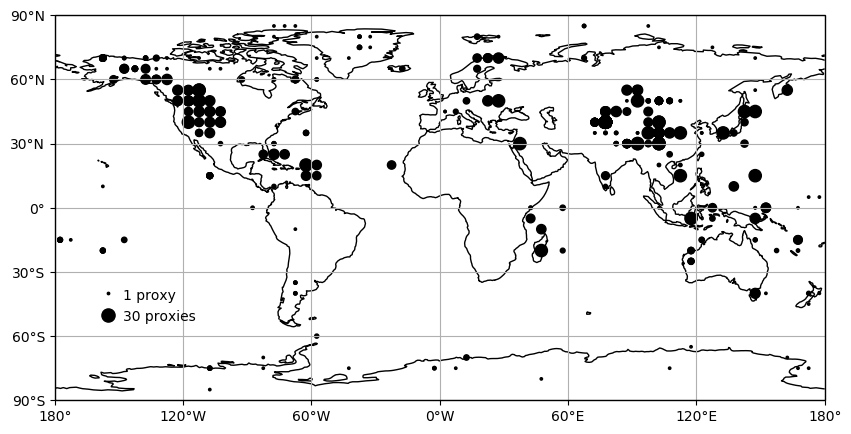

In [40]:
# Plot HadCRUT and pproxy data locations
import cartopy.util as cutil
import cartopy.crs as ccrs

npp = np.empty([len(vYe_coords_temp),1])
for ii in np.arange(len(vYe_coords_temp)):
    npp[ii] = np.sum((vYe_coords_temp[:,0]==vYe_coords_temp[ii,0]) & 
                    ((vYe_coords_temp[:,1]==vYe_coords_temp[ii,1])))
    
    
vYe_coords_plot = vYe_coords_temp[c_dat,:]

#plt.imshow(165-np.flipud(np.sum(np.isnan(value),0)))
#plt.title('Number of years with obs in HadCRUT')
#plt.colorbar()
#plt.show()

fig = plt.figure(figsize=(10,5))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
#gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0.), draw_labels=True,
#                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.grid(True,which='major',axis='both')
ax.coastlines()
ax.scatter(vYe_coords_temp[:,1]+2.5,vYe_coords_temp[:,0]+2.5,c='k',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))
ax.scatter(vYe_coords_plot[:,1]+2.5,vYe_coords_plot[:,0]+2.5,c='k',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))
#plt.title('Locations with greater than '+str(nc)+' continuous obs in HadCRUT  \n plus PAGES2k locations')
#plt.colorbar()

ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.scatter(-155,-40,s=3,transform=ccrs.PlateCarree(central_longitude=0.),c='k')
ax.scatter(-155,-50,s=90,transform=ccrs.PlateCarree(central_longitude=0.),c='k')
ax.text(-148,-43,'1 proxy')
ax.text(-148,-53,'30 proxies')

#ax.pcolor(wrap_lon,grid.lat[:,0],~wrap_data,cmap='bone',vmin = -7)
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/pproxy_locs.pdf')
plt.show()



In [41]:
# Compare what happens for various truth-prior pairs
# Things to include: localization, SNR, ob network

from itertools import compress

grid = ad[0]['grid']
grids = grid

NENS = grid.nens
LOCRAD = 0.0
SNR = 0.4

# Initialize array of dictionaries containing the different comparisons
cdd = []

# Loop over prior files
for ii in np.arange(len(lmr_names)+1):

    # Key steps: Eliminate yes and pproxies at incomplete spots

    # Compute effective observations
    vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

    # Remove places that don't meet the complete obs requirement
    vYe_coords = vYe_coords[c_dat,:]
    vYe = vYe[c_dat,:]
    
    # change the localization radius in the config file
    #cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
    #cfg_new = LMR_config.Config(**cfg_params)

    # Loop over truth files
    for jj in np.arange(len(lmr_names)+1):

        # Use a precomputed interpolated version of the truth
        # Set values that aren't sampled by HadCRUT to zero
        vY, vR, vP = mk_pproxies(ad[jj]['X'],
                                 ad[jj]['Xbp'],
                                 prox_manager,SNR,ad[jj]['grid'])
        
        # Sanity check:
        # plt.matshow((ad[0]['Xbp']*np.tile(complete.ravel(),[50,1]).T)[:,0].reshape([36,72]))
        
        vR = list(compress(vR,c_dat))
        vP = list(compress(vP,c_dat))
        vY = vY[c_dat,:]
        
        fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])

        # Loop over ensemble members
        for kk in np.arange(NENS):
            if LOCRAD==0.:
                f,Xap,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,ad[ii]['Xbp']*mask,verbose=False)
            else:
                f,Xap2 = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,ad[ii]['Xbp']*mask,X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)

            fp[:,kk] = f

        # Store information in a dictionary for this prior-truth pair
        c = {}
        c['locrad']     = LOCRAD
        c['snr']        = SNR
        c['prior_name'] = ad[ii]['name']
        c['truth_name'] = ad[jj]['name']
        c['pind']       = ii
        c['tind']       = jj
        c['recon']      = fp
        c['rmse']       = np.mean((ad[jj]['Xbp'][:,:NENS]*nanmask-fp)**2,1)**.5

        # Concatenate the dictionary to a list corresponding to all prior-truth pairs 
        # for the choices of LOCRAD and SNR
        cdd.append(c)

# Save all prior-truth pairs for these choices of LOCRAD and SNR
#print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
#np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)
print('Done!')        

Done!


In [52]:
# Plot RMS error

def plt_rmse(cdd,title):

    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))

    fig = plt.figure(figsize=(16,12))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(4, 4),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    for ii, ax in enumerate(axgr):

        rmsc = cdd[ii]['rmse']**2

        cldat = rmsc.reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=10.0,
                        transform=projection,
                        cmap='YlOrRd',
                        )

        ax.coastlines(color='gray')
        if cdd[ii]['pind']==2:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        if cdd[ii]['tind'] == 0:
            ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)

        plt.title('Prior: '+ cdd[ii]['prior_name'] + ', truth: ' + cdd[ii]['truth_name'])
        
    cb=axgr.cbar_axes[0].colorbar(p)
    fig.suptitle(title, fontsize=14)
    plt.show();


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


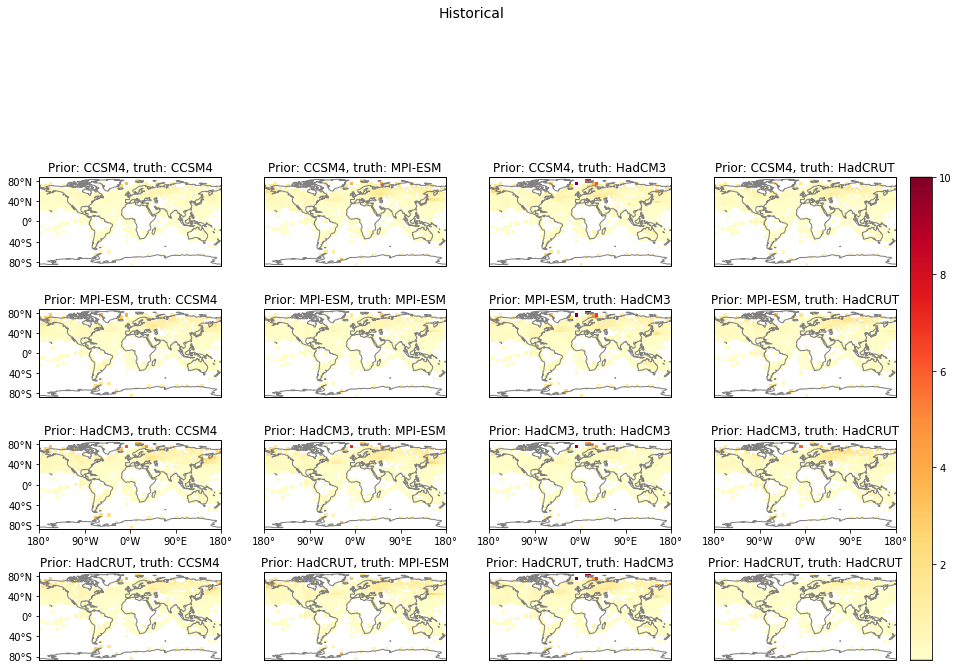

In [53]:
    title = 'Historical'
    plt_rmse(cdd,title)

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


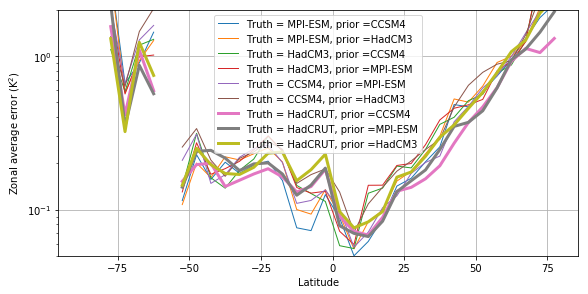

In [54]:
# Zonal means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
#SNR = '0.4'
#cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_100.0.npy')
#cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

key = np.array([1,9,2,6,4,8,3,7,11])

#for ii in np.arange(3):
fig = plt.figure(figsize=(8,4))
#plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
#plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
#plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
for _,ii in enumerate(key):
    if np.mod(ii+1,4)==0:
        plt.semilogy(lat,np.nanmean(cdd[ii]['rmse'].reshape([36,72])**2,1),linewidth=3)
    else:
        plt.semilogy(lat,np.nanmean(cdd[ii]['rmse'].reshape([36,72])**2,1),linewidth=1)


    plt.tight_layout()
plt.ylabel('Zonal average error (K$^2$)')
plt.ylim([-0.25,2.,])
#plt.xlim([-80.,80.])
plt.xlabel('Latitude')
#plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
plt.legend([#'SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
            'Truth = '+cdd[key[0]]['truth_name']+', prior ='+cdd[key[0]]['prior_name'],
            'Truth = '+cdd[key[1]]['truth_name']+', prior ='+cdd[key[1]]['prior_name'],
            'Truth = '+cdd[key[2]]['truth_name']+', prior ='+cdd[key[2]]['prior_name'],
            'Truth = '+cdd[key[3]]['truth_name']+', prior ='+cdd[key[3]]['prior_name'],
            'Truth = '+cdd[key[4]]['truth_name']+', prior ='+cdd[key[4]]['prior_name'],
            'Truth = '+cdd[key[5]]['truth_name']+', prior ='+cdd[key[5]]['prior_name'],
            'Truth = '+cdd[key[6]]['truth_name']+', prior ='+cdd[key[6]]['prior_name'],
            'Truth = '+cdd[key[7]]['truth_name']+', prior ='+cdd[key[7]]['prior_name'],
            'Truth = '+cdd[key[8]]['truth_name']+', prior ='+cdd[key[8]]['prior_name']
           ])#,frameon=False)#,bbox_to_anchor=(1.1, .95))
plt.grid()
plt.show();


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


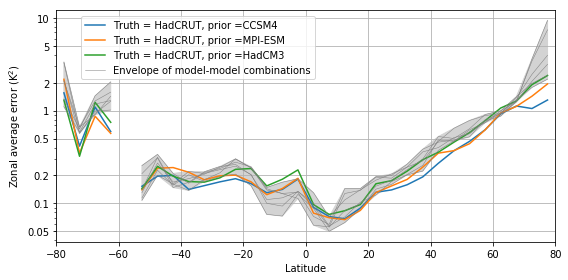

In [123]:
# Zonal means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
#SNR = '0.4'
#cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_100.0.npy')
#cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_'+SNR+'.npy')
SNR = '0.4'

cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

# Compute the envelope
allmod = np.array([1,9,2,6,4,8])
lm = np.empty([len(lat),len(allmod)])
for counter,value in enumerate(allmod):
    lm[:,counter] = np.nanmean(cdd[value]['rmse'].reshape([36,72])**2,1)

key = np.array([3,7,11])

#for ii in np.arange(3):
fig = plt.figure(figsize=(8,4))
plt.fill_between(lat,np.nanmax(lm,1),np.nanmin(lm,1),color='lightgray')
#plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
#plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
#plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
for _,ii in enumerate(key):
    plt.semilogy(lat,np.nanmean(cdd[ii]['rmse'].reshape([36,72])**2,1))
for _,ii in enumerate(allmod):
    plt.semilogy(lat,np.nanmean(cdd[ii]['rmse'].reshape([36,72])**2,1),c='gray',linewidth=.5)

plt.ylabel('Zonal average error (K$^2$)')
#plt.ylim([-0.001,10.,])
plt.xlim([-80.,80.])
plt.xlabel('Latitude')
#plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
plt.legend([#'SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
            'Truth = '+cdd[key[0]]['truth_name']+', prior ='+cdd[key[0]]['prior_name'],
            'Truth = '+cdd[key[1]]['truth_name']+', prior ='+cdd[key[1]]['prior_name'],
            'Truth = '+cdd[key[2]]['truth_name']+', prior ='+cdd[key[2]]['prior_name'],
            'Envelope of model-model combinations'],
            frameon=True,bbox_to_anchor=(.04, .68))
plt.grid()
plt.yticks([0.05,0.1,0.2,0.5,1.,2,5,10],['0.05','0.1','0.2','0.5','1','2','5','10'])
plt.tight_layout()
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/CRUT_model_zmeans.pdf')
plt.show();


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: All-NaN slice encountered
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: All-NaN slice encounte

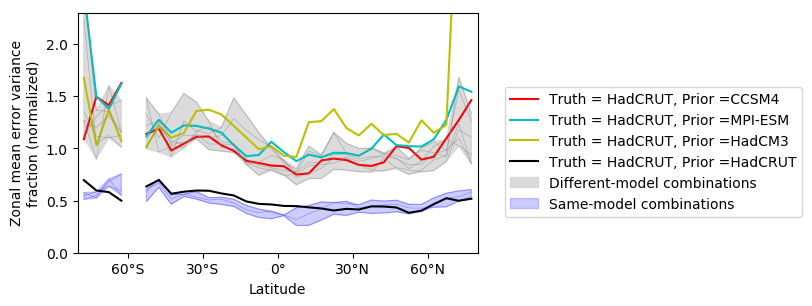

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


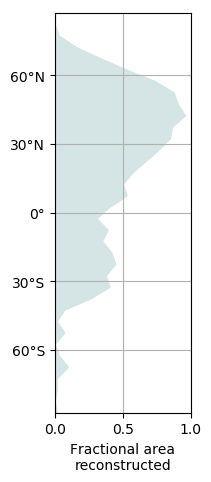

In [47]:
# Now normalized by truth variance
# Zonal means plot

importlib.reload(plt)
plt.style.use('default')

lat = ad[0]['grid'].lat[:,0]

# Compute the envelope
# These are the model-model cases
allmod       = np.array([1,9,2,6,4,8])
#allmod       = np.array([1,2,4,6,8,9])
allmod_truth = np.array([0,5,10])
# key are the non model-model cases
key = np.array([3,7,11])

lm = np.empty([len(lat),len(allmod)])
for counter,value in enumerate(allmod):
#    print(value)
    lm[:,counter] = np.nanmean(
                               cdd[value]['rmse'].reshape([36,72])**2/
                               (np.var(ad[cdd[value]['tind']]['Xbp'],1).reshape([36,72]))
                            ,1)
    

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

plt.plot(lat,np.nanmean(cdd[3]['rmse'].reshape([36,72])**2/
                            np.var(ad[cdd[3]['tind']]['Xbp'],1).reshape([36,72]),1),'r')
plt.plot(lat,np.nanmean(cdd[7]['rmse'].reshape([36,72])**2/
                            np.var(ad[cdd[7]['tind']]['Xbp'],1).reshape([36,72]),1),'c')
plt.plot(lat,np.nanmean(cdd[11]['rmse'].reshape([36,72])**2/
                            np.var(ad[cdd[11]['tind']]['Xbp'],1).reshape([36,72]),1),'y')
plt.plot(lat,np.nanmean(cdd[15]['rmse'].reshape([36,72])**2/
                            np.var(ad[cdd[15]['tind']]['Xbp'],1).reshape([36,72]),1),'k')

plt.fill_between(lat,np.nanmin(lm,1),np.nanmax(lm,1),color='lightgray',alpha = .8)
plt.plot(lat,lm,c='gray',linewidth=.5,alpha=.5,label='_nolegend_')


lmt = np.empty([len(lat),len(allmod_truth)])
for counter,value in enumerate(allmod_truth):
#    print(value)
    lmt[:,counter] = np.nanmean(
                               cdd[value]['rmse'].reshape([36,72])**2/
                               (np.var(ad[cdd[value]['tind']]['Xbp'],1).reshape([36,72]))
                            ,1)
plt.fill_between(lat,np.nanmin(lmt,1),np.nanmax(lmt,1),color='blue',alpha = .2)
plt.plot(lat,lmt,c='blue',linewidth=.5,alpha=.3,label='_nolegend_')


plt.ylabel('Zonal mean error variance\nfraction (normalized)')
plt.ylim([0.,2.3])
plt.xlim([-80.,80.])
plt.xlabel('Latitude')
plt.tight_layout()
#plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
lgd = plt.legend([#'SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
            'Truth = '+cdd[key[0]]['truth_name']+', Prior ='+cdd[key[0]]['prior_name'],
            'Truth = '+cdd[key[1]]['truth_name']+', Prior ='+cdd[key[1]]['prior_name'],
            'Truth = '+cdd[key[2]]['truth_name']+', Prior ='+cdd[key[2]]['prior_name'],
            'Truth = '+cdd[15]['truth_name']+', Prior ='+cdd[15]['prior_name'],
            'Different-model combinations',
            'Same-model combinations'],
            frameon=True,bbox_to_anchor=(1.05, .72))
plt.xticks([-60,-30,0,30,60])
ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
#plt.grid()
#plt.yticks([0.05,0.1,0.2,0.5,1.,2,5,10],['0.05','0.1','0.2','0.5','1','2','5','10'])
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/CRUT_model_zmeans_norm_detrend.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show();

#fig = plt.figure(figsize=(6,1.5))
#plt.fill_between(lat,0,np.sum(complete,1)/72.,color='lightgray',alpha = .8) #(213./255.,228./255.,228./255.))
##plt.plot(lat,np.sum(complete,1)/72.,'k',linewidth=.8)
#plt.xlim([-80.,80.])
#plt.ylabel('Fractional area\nreconstructed')
#plt.xlabel('Latitude')
#plt.ylim([0.,1.1])
#plt.tight_layout()
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/CRUT_model_zmeans_norm_extent.pdf')
#plt.show()

fig = plt.figure(figsize=(1.7,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.fill_betweenx(lat,0,np.sum(complete,1)/72.,color=(213./255.,228./255.,228./255.))
#plt.plot(lat,np.sum(complete,1)/72.,'k',linewidth=.8)
plt.xlabel('Fractional area\nreconstructed')
#plt.xlabel('Latitude')
plt.xlim([0.,1.])
plt.yticks([-60, -30, 0, 30, 60,])
ax.set_yticklabels(['60°S','30°S','0°','30°N','60°N'])
plt.ylim([-87.5,87.5])
plt.tight_layout()
plt.grid()
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/CRUT_model_zmeans_norm_extent_vert_detrend.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: All-NaN slice encountered
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: All-NaN slice encounte

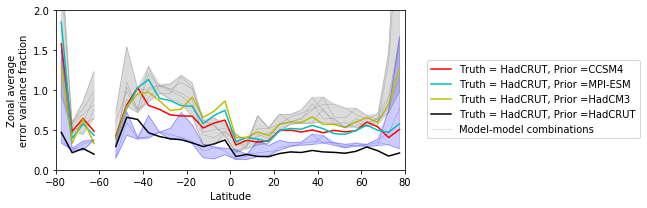

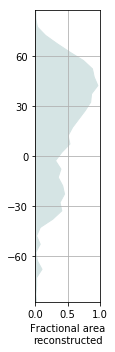

In [213]:
# Now normalized by HadCM3 zonal mean variance (idea: just for scaling!)
# But maybe this makes less sense -- what if the target fields had quite different variances?
# Zonal means plot

lat = ad[0]['grid'].lat[:,0]

# Zonal normalization vector
zn = np.mean(np.var(ad[0]['Xbp'],1).reshape([36,72]),1)

# Compute the envelope
# These are the model-model cases
#allmod       = np.array([1,9,2,6,4,8])
allmod       = np.array([1,2,4,6,8,9])
allmod_truth = np.array([0,5,10])
# key are the non model-model cases
key = np.array([3,7,11])

lm = np.empty([len(lat),len(allmod)])
for counter,value in enumerate(allmod):
#    print(value)
    lm[:,counter] = np.nanmean(
                               cdd[value]['rmse'].reshape([36,72])**2,1)/zn

fig = plt.figure(figsize=(6,3))

plt.plot(lat,np.nanmean(cdd[ 3]['rmse'].reshape([36,72])**2,1)/zn,'r')
plt.plot(lat,np.nanmean(cdd[ 7]['rmse'].reshape([36,72])**2,1)/zn,'c')
plt.plot(lat,np.nanmean(cdd[11]['rmse'].reshape([36,72])**2,1)/zn,'y')
plt.plot(lat,np.nanmean(cdd[15]['rmse'].reshape([36,72])**2,1)/zn,'k')

plt.fill_between(lat,np.nanmin(lm,1),np.nanmax(lm,1),color='lightgray',alpha = .8)
plt.plot(lat,lm,c='gray',linewidth=.5,alpha=.5)


lmt = np.empty([len(lat),len(allmod_truth)])
for counter,value in enumerate(allmod_truth):
#    print(value)
    lmt[:,counter] = np.nanmean(
                               cdd[value]['rmse'].reshape([36,72])**2,1)/zn

plt.fill_between(lat,np.nanmin(lmt,1),np.nanmax(lmt,1),color='blue',alpha = .2)
plt.plot(lat,lmt,c='blue',linewidth=.5,alpha=.3)


plt.ylabel('Zonal average\nerror variance fraction')
plt.ylim([0.,2.])
plt.xlim([-80.,80.])
plt.xlabel('Latitude')
plt.tight_layout()
#plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
lgd = plt.legend([#'SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
            'Truth = '+cdd[key[0]]['truth_name']+', Prior ='+cdd[key[0]]['prior_name'],
            'Truth = '+cdd[key[1]]['truth_name']+', Prior ='+cdd[key[1]]['prior_name'],
            'Truth = '+cdd[key[2]]['truth_name']+', Prior ='+cdd[key[2]]['prior_name'],
            'Truth = '+cdd[15]['truth_name']+', Prior ='+cdd[15]['prior_name'],
            'Model-model combinations'],
            frameon=True,bbox_to_anchor=(1.05, .72))
#plt.grid()
#plt.yticks([0.05,0.1,0.2,0.5,1.,2,5,10],['0.05','0.1','0.2','0.5','1','2','5','10'])
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/CRUT_model_zmeans_norm.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show();

#fig = plt.figure(figsize=(6,1.5))
#plt.fill_between(lat,0,np.sum(complete,1)/72.,color='lightgray',alpha = .8) #(213./255.,228./255.,228./255.))
##plt.plot(lat,np.sum(complete,1)/72.,'k',linewidth=.8)
#plt.xlim([-80.,80.])
#plt.ylabel('Fractional area\nreconstructed')
#plt.xlabel('Latitude')
#plt.ylim([0.,1.1])
#plt.tight_layout()
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/CRUT_model_zmeans_norm_extent.pdf')
#plt.show()

fig = plt.figure(figsize=(1.7,5))
plt.fill_betweenx(lat,0,np.sum(complete,1)/72.,color=(213./255.,228./255.,228./255.))
#plt.plot(lat,np.sum(complete,1)/72.,'k',linewidth=.8)
plt.xlabel('Fractional area\nreconstructed')
#plt.xlabel('Latitude')
plt.xlim([0.,1.])
plt.yticks([-90, -60, -30, 0, 30, 60, 90])
plt.ylim([-87.5,87.5])
plt.tight_layout()
plt.grid()
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/CRUT_model_zmeans_norm_extent_vert.pdf')
plt.show()


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: All-NaN slice encountered
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: All-NaN slice encounte

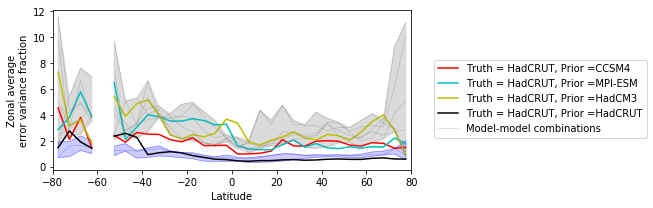

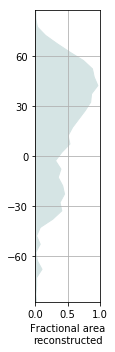

In [194]:
# Now normalized by RECON variance
# Zonal means plot

lat = ad[0]['grid'].lat[:,0]

# Compute the envelope
# These are the model-model cases
allmod       = np.array([1,9,2,6,4,8])
allmod_truth = np.array([0,5,10])
# key are the non model-model cases
key = np.array([3,7,11])

lm = np.empty([len(lat),len(allmod)])
for counter,value in enumerate(allmod):
#    print(value)
    lm[:,counter] = np.nanmean(
                               cdd[value]['rmse'].reshape([36,72])**2/
                               (np.var(cdd[value]['recon'],1).reshape([36,72]))
                            ,1)
    

fig = plt.figure(figsize=(6,3))

plt.plot(lat,np.nanmean(cdd[3]['rmse'].reshape([36,72])**2/
                            np.var(cdd[3]['recon'],1).reshape([36,72]),1),'r')
plt.plot(lat,np.nanmean(cdd[7]['rmse'].reshape([36,72])**2/
                            np.var(cdd[7]['recon'],1).reshape([36,72]),1),'c')
plt.plot(lat,np.nanmean(cdd[11]['rmse'].reshape([36,72])**2/
                            np.var(cdd[11]['recon'],1).reshape([36,72]),1),'y')
plt.plot(lat,np.nanmean(cdd[15]['rmse'].reshape([36,72])**2/
                            np.var(cdd[15]['recon'],1).reshape([36,72]),1),'k')
plt.fill_between(lat,np.nanmin(lm,1),np.nanmax(lm,1),color='lightgray',alpha = .8)
plt.plot(lat,lm,c='gray',linewidth=.5,alpha=.5)


lmt = np.empty([len(lat),len(allmod_truth)])
for counter,value in enumerate(allmod_truth):
#    print(value)
    lmt[:,counter] = np.nanmean(
                               cdd[value]['rmse'].reshape([36,72])**2/
                               np.var(cdd[value]['recon'],1).reshape([36,72])
                            ,1)
plt.fill_between(lat,np.nanmin(lmt,1),np.nanmax(lmt,1),color='blue',alpha = .2)
plt.plot(lat,lmt,c='blue',linewidth=.5,alpha=.3)


plt.ylabel('Zonal average\nerror variance fraction')
#plt.ylim([0.,2.3])
plt.xlim([-80.,80.])
plt.xlabel('Latitude')
plt.tight_layout()
#plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
lgd = plt.legend([#'SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
            #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
            'Truth = '+cdd[key[0]]['truth_name']+', Prior ='+cdd[key[0]]['prior_name'],
            'Truth = '+cdd[key[1]]['truth_name']+', Prior ='+cdd[key[1]]['prior_name'],
            'Truth = '+cdd[key[2]]['truth_name']+', Prior ='+cdd[key[2]]['prior_name'],
            'Truth = '+cdd[15]['truth_name']+', Prior ='+cdd[15]['prior_name'],
            'Model-model combinations'],
            frameon=True,bbox_to_anchor=(1.05, .72))
#plt.grid()
#plt.yticks([0.05,0.1,0.2,0.5,1.,2,5,10],['0.05','0.1','0.2','0.5','1','2','5','10'])
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/CRUT_model_zmeans_norm.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show();

#fig = plt.figure(figsize=(6,1.5))
#plt.fill_between(lat,0,np.sum(complete,1)/72.,color='lightgray',alpha = .8) #(213./255.,228./255.,228./255.))
##plt.plot(lat,np.sum(complete,1)/72.,'k',linewidth=.8)
#plt.xlim([-80.,80.])
#plt.ylabel('Fractional area\nreconstructed')
#plt.xlabel('Latitude')
#plt.ylim([0.,1.1])
#plt.tight_layout()
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/CRUT_model_zmeans_norm_extent.pdf')
#plt.show()

fig = plt.figure(figsize=(1.7,5))
plt.fill_betweenx(lat,0,np.sum(complete,1)/72.,color=(213./255.,228./255.,228./255.))
#plt.plot(lat,np.sum(complete,1)/72.,'k',linewidth=.8)
plt.xlabel('Fractional area\nreconstructed')
#plt.xlabel('Latitude')
plt.xlim([0.,1.])
plt.yticks([-90, -60, -30, 0, 30, 60, 90])
plt.ylim([-87.5,87.5])
plt.tight_layout()
plt.grid()
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/CRUT_model_zmeans_norm_extent_vert.pdf')
plt.show()


MPI-ESMCCSM4
MPI-ESMMPI-ESM

MPI-ESMHadCM3
MPI-ESMMPI-ESM

HadCM3CCSM4
HadCM3HadCM3

HadCM3MPI-ESM
HadCM3HadCM3

CCSM4MPI-ESM
CCSM4CCSM4

CCSM4HadCM3
CCSM4CCSM4



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: All-NaN slice encountered
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not

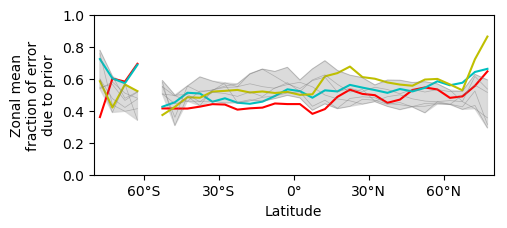

In [48]:
# Fractions due to physical uncertainty
importlib.reload(plt)
plt.style.use('default')

fig = plt.figure(figsize=(5,2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

crutr = cdd[15]['rmse'].reshape([36,72])**2

plt.plot(lat,np.nanmean((cdd[3]['rmse'].reshape([36,72])**2-crutr)/
                            cdd[3]['rmse'].reshape([36,72])**2,1),'r')
plt.plot(lat,np.nanmean((cdd[7]['rmse'].reshape([36,72])**2-crutr)/
                            cdd[7]['rmse'].reshape([36,72])**2,1),'c')
plt.plot(lat,np.nanmean((cdd[11]['rmse'].reshape([36,72])**2-crutr)/
                            cdd[11]['rmse'].reshape([36,72])**2,1),'y')
         
#allmod       = np.array([1,2,4,6,8,9])
allmod       = np.array([1,9,2,6,4,8])
allmod_truth = np.array([5,5,10,10,0,0])

lmf = np.empty([len(lat),len(allmod)])
for counter,value in enumerate(allmod):
    print(cdd[value]['truth_name']+cdd[value]['prior_name'])
    print(cdd[allmod_truth[counter]]['truth_name']+cdd[allmod_truth[counter]]['prior_name']+'\n')

    ptr = cdd[value]['rmse'].reshape([36,72])**2
    ttr = cdd[allmod_truth[counter]]['rmse'].reshape([36,72])**2
    lmf[:,counter] = np.nanmean((ptr-ttr)/ptr,1)

plt.fill_between(lat,np.nanmin(lmf,1),np.nanmax(lmf,1),color='lightgray',alpha = .8)
plt.plot(lat,lmf,c='gray',linewidth=.5,alpha=.5)


plt.ylabel('Zonal mean\nfraction of error\ndue to prior')
plt.ylim([0.,1.0])
plt.xlim([-80.,80.])
plt.xlabel('Latitude')
plt.tight_layout()

#lgd = plt.legend([#'SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
#            #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
#            #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
#            'Truth = '+cdd[key[0]]['truth_name']+', Prior ='+cdd[key[0]]['prior_name'],
#            'Truth = '+cdd[key[1]]['truth_name']+', Prior ='+cdd[key[1]]['prior_name'],
#            'Truth = '+cdd[key[2]]['truth_name']+', Prior ='+cdd[key[2]]['prior_name'],
#            'Model-model combinations'],
#            frameon=True,bbox_to_anchor=(1.05, .72))
plt.xticks([-60,-30,0,30,60])
ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/CRUT_model_zmeans_frac_norm_detrend.pdf', bbox_inches='tight')
plt.show();

In [66]:
#
# specify a localized function for the truth state, and then test its recovery
#
var = list(X.statevars.keys())[0]
# center point for the function max
site_lat = 40.
site_lon = 330.
X_lat = X.prior_dict[var]['lat']
X_lon = X.prior_dict[var]['lon']
# distance from the max
dists = np.array(LMR_utils.haversine(site_lon, site_lat,X_lon,X_lat),dtype=np.float64)

# specify a decay length scale
locRad = 10000.

# gaussian
gauss = np.exp(-(dists/(locRad/2))**2)

In [126]:
# draw new "pseudoproxies" from the known field (hacked from LMR_lite_utils)
#
# this block draws observations from locations of the proxies specified in the config file
#
nlat = grid.nlat
nlon = grid.nlon

vY = []
vR = []
vP = []
vYe = np.zeros([numprox,grid.nens])
vYe_coords = np.zeros([numprox,2])

for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
    #print(Y.lat,Y.lon)
    # get grid indices
    tmp = grid.lat[:,0]-Y.lat
    itlat = np.argmin(np.abs(tmp))
    tmp = grid.lon[0,:]-Y.lon
    itlon = np.argmin(np.abs(tmp))
    # check that we have the correct point
    #print(itlat,itlon)
    #print('orig:',"%4.1f"%Y.lat,Y.lon)
    #print('check:'"%4.1f"%grid.lat[itlat,0],grid.lon[0,itlon])    
    # the observations
    vY.append(gauss[itlat,itlon])
    vR.append(0.001)
    vP.append(proxy_idx)
    # the ensemble prior estimates
    npos = itlat*nlon + itlon
    vYe[proxy_idx,:] = Xbp[npos,:]
    vYe_coords[proxy_idx,:] = X.coords[npos,:]

print(vYe.shape)
print(vYe_coords.shape)
print(len(vY))
print(len(vP))

(542, 50)
(542, 2)
542
542


In [127]:
# option to change the localization radius in the config file (used by DA code)
print(cfg.core.loc_rad)
cfg_params = LMR_utils.param_cfg_update('core.loc_rad',5000.)
cfg_new = LMR_config.Config(**cfg_params)

print(cfg_new.core.loc_rad)

25000
5000.0


In [128]:
xam,Xap,_ = LMRlite.Kalman_optimal(vY,vR,vYe,Xbp,verbose=True)
xam2,Xap2 = LMRlite.Kalman_ESRF(cfg_new,vY,vR,vYe,Xbp,X=X,vYe_coords=vYe_coords,verbose=True)


 all-at-once solve...

number of obs: 542
number of ensemble members: 50
ndof :50
U :(542, 542)
s :(50,)
V :(50, 50)
recontructing using 49 singular values
min s: 2.1489730747189385e-14
shape of U: (542, 542)
shape of s: (50,)
shape of V: (50, 50)
-----------------------------------------------------
completed in 0.04381608963012695 seconds
-----------------------------------------------------
Ensemble square root filter...
Xb shape: (3134, 50)
X coords shape (2592, 2)
X aug coords shape (3134, 2)
appended state...
-----------------------------------------------------
completed in 0.7150142192840576 seconds
-----------------------------------------------------


In [129]:
def mapplot(map,grid):
    fig = plt.figure(figsize=(8,4))
    r2w, wrap_lon = cutil.add_cyclic_point(map, coord=grid.lon[0,:], axis=1)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='RdBu_r',vmin=-1,vmax=1)
    ax.coastlines(color='gray')

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,c='k',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))


    
    return ax




/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


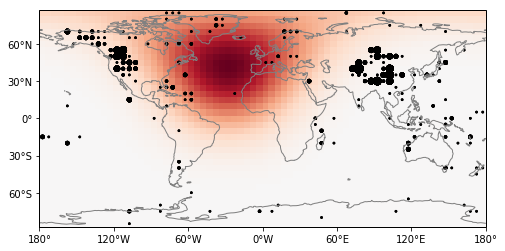

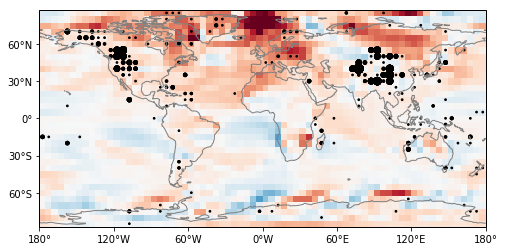

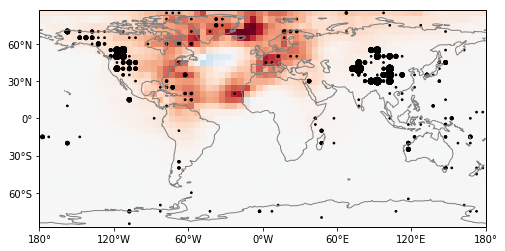

In [132]:
ax=mapplot(gauss,grid)
npp = np.empty([len(vYe_coords),1])
for ii in np.arange(len(vYe_coords)):
    npp[ii] = np.sum((vYe_coords[:,0]==vYe_coords[ii,0]) & 
                    ((vYe_coords[:,1]==vYe_coords[ii,1])))
    
#ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
#gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0.), draw_labels=True,
#                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax.grid(True,which='major',axis='both')
#ax.coastlines()
ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,c='k',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))

xam_lalo = np.reshape(xam,[grid.nlat,grid.nlon])
xam_lalo2 = np.reshape(xam2,[grid.nlat,grid.nlon])

mapplot(xam_lalo,grid)
mapplot(xam_lalo2,grid)

